# Assignment 1: Tabular Methods

Name: Aditya Raj Verma

ID:   A53219148

This exercise requires you to solve a simple grid-world problem called 'FrozenLake-v0' in OpenAI Gym.  We will solve the problem in two different ways. First we will solve the problem using dynamic programming, thus requiring a model of the system. Second we will do it using model-free temporal difference (Q-Learning). Finally, as a bonus you may also show it learning using a naive approach called hill-climbing. 

### Required for all 
#### Set up environment

In [1]:
%matplotlib inline
import gym
import numpy as np
from matplotlib import pyplot as plt
env = gym.make('FrozenLake-v0')

#### Pre. Test Policy Function
Write a function to test a policy. Return the average rate of successful episodes over 100 trials. 

In [2]:
def runEpisode(policy):
    state, reward, done = [env.reset(), 0, False]
    while not done:
        state, reward, done , _ = env.step(policy[state])
    return reward
    
def testPolicy(policy):
    #%% ---> start of code
    #%% <--- end of code
    nSuccess = 0
    for i in range(100):
        nSuccess += 1 if runEpisode(policy) else 0
    percentSuccess = nSuccess/100.0
    return percentSuccess

## Model-based Learning

### 1. Policy Iteration
Perform policy iteration on the Frozenlake example. 


#### 1.1 Find the system model
First, model $T(s,a,s')$ and $R(s,a,s')$ over 100000 randomly initializations.

In [3]:
def learnModelUtil():
    state, reward, done = [env.reset(), 0, False]
    sas_count = np.zeros((16, 4, 16))
    sa_count  = np.zeros((16, 4, 1))
    r_sas     = np.zeros((16, 4, 16))
    for state in range(16):
        for action in range(4):
            env.env.s = state
            next_state, reward, _ , _ = env.step(action)

            sas_count[state,action,next_state] += 1
            sa_count[state,action, 0] += 1
            r_sas[state,action,next_state] += reward

    return sa_count, sas_count, r_sas

def learnModel():
    #%% ---> start of code
    #%% <--- end of code
    nTrials = 100000
    overall_sa_count  = np.zeros((16, 4, 1))+0.0001
    overall_sas_count = np.zeros((16, 4, 16))+0.0001
    overall_r_sas     = np.zeros((16, 4, 16))

    for i in range(nTrials):
        sa_count, sas_count, r_sas = learnModelUtil()
        overall_sa_count += sa_count
        overall_sas_count += sas_count
        overall_r_sas += r_sas
    
    T = np.around(overall_sas_count/overall_sa_count, 4)
    R = np.around(overall_r_sas/overall_sas_count, 4)
    env.reset()
    return R,T

#first learn the model    
[R,T] = learnModel()

#### 1.2 What does the transition model tell you about the stochastic behavior of actions? What does it tell you about the stochasticity  of the rewards? What would you expect an optimal agent's policy to do?

Answer: <br>
From the Transition model, it seems that the surface is highly slippery. Inspite of taking any particular action(Left, right, etc), for many of the states, almost 33% times we landed at a different state different from the expected state.

From the Reward model, we see that we get a positive reward only when at state 14. This indicates that the agent needs to somehow make its way to state 14 after which it can get some reward.

#### 1.3 Write a function for Policy Evaluation

In [4]:
#runPolicyEvaluation:
def runPolicyEvaluation(policy,V,R,T,discount_factor):
#     bp()
    #%% ---> start of code
    #%% <--- end of code
    discountedV = discount_factor * V
    Vnew = np.zeros_like(V)
    state = 2
    next_state = 2
    for state in range(16):
        for next_state in range(16):
                Vnew[state] += ( T[state, policy[state], next_state] * ( R[state, policy[state], next_state] + discountedV[next_state] ) )
    return Vnew

def updatePolicy(V, discount_factor):
    discountedV = discount_factor * V.reshape([1,-1])
    policy = np.zeros(16).astype(int)
    for state in range(16):
        r = np.sum( T[state]*(R[state] + discountedV), axis = 1 )
        policy[state] = np.argmax(r)
    return policy

#### 1.4 Run Policy iteration.
and show a bar graph of successful runs vs iteration on the policy. Use a discount factor of 0.98, and terminate policy  after 40 iterations of policy updates.  Plot the percentSuccesses at every iteration (i.e. the return of the testPolicy function).

('Policy iteration policy:', array([0, 3, 0, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0]))


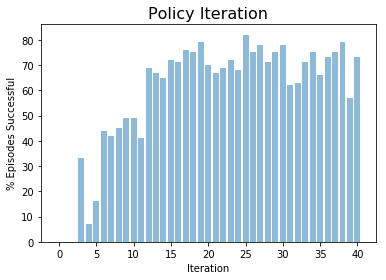

In [5]:
#%% ---> start of code
#%% <--- end of code
discount_factor = 0.98
V = np.zeros(16)
policy = np.random.randint(4, size=16)

percentSuccesses = []
percentSuccesses.append(testPolicy(policy))
for i in range(40):
    V = runPolicyEvaluation(policy,V,R,T,discount_factor)
    policy = updatePolicy(V, discount_factor)
    acc = testPolicy(policy)
    percentSuccesses.append(acc)

    
# plot improvement over time
plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iteration')
plt.title('Policy Iteration',fontsize=16)
print('Policy iteration policy:', policy)

## Model-Free Learning

### 2 Q Value-Iteration (Q-Learning)

#### 2.1 Set up a Q learning function
Set your exploration rate to 1-episode_num/total_num_of_episodes for linear convergence from completely random action selection to a greedy policy. Return a set of policies (at 5%, 10%,...100% of the total number of episodes) so that in the later section you can perform policy evaluation on intermediate Q-tables and show progress.

In [6]:
def runQLearning(learning_rate,discount_factor,num_of_episodes,Q0,explore_type='linear'):
    #%% code starts here
    #%% code ends here
    Qsa = np.copy(Q0)
    Qnew = np.zeros_like(Qsa)
    policies = []
    for episode_num in range(1,num_of_episodes+1):
        env.reset()
        policy = getPolicy(Qsa)
        Qnew = np.copy(Qsa)
        if explore_type == 'linear':
            eps = 1 - episode_num/float(num_of_episodes)
        elif explore_type == 'log':
            eps = 1 - (1000/(1000.0 + episode_num))
        else:
            print "Error: Unsupported exploration type ", explore_type
            break
        
        for state in range(16):
            env.env.s = state
            # choose action as per epsilon-greedy
            if np.random.uniform() < eps:
                action = np.random.randint(env.action_space.n)
            else:
                action = policy[state]
        
            # execute step
            next_state, reward, _ , _ = env.step(action)
#             bp()
            try:
                Qnew[state, action] += learning_rate*(reward + discount_factor*Qsa[next_state].max() - Qsa[state, action] )
            except Exception as e:
                print e
                bp()
        Qsa = np.copy(Qnew)
        
        if( (20*episode_num) % (num_of_episodes) == 0):
            policy = getPolicy(Qsa)
            policies.append(policy)
        
    return Qsa, policies

def getPolicy(Qsa):
    policy = np.zeros((env.observation_space.n))
    for state in range(env.observation_space.n):
        policy[state] = Qsa[state].argmax()
    return policy.astype(int)

#### 2.1 Perform Q-learning. 
Show policies during intermediate phases of Q-learning, at 0, 10%, 20%,...,100% of the total episodes during training. Set a learning rate of 0.98 and a discount factor of 0.95. Start with a zero-filled Q-table. Run 10000 episodes. Plot the bar graph of the success rate over time to visualize the improvements to success rate the new policies are providing. 

('Q-learning (linear) policy:', array([0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]))


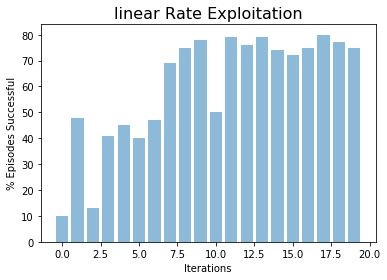

In [7]:
#%% ---> start of code
#%% <--- end of code
learning_rate = 0.02
discount_factor = 0.95
num_of_episodes = 10000
Q0 = np.zeros([env.observation_space.n, env.action_space.n])
Qsa, policies = runQLearning(learning_rate,discount_factor,num_of_episodes,Q0,explore_type='linear')
percentSuccesses = []
for i, policy in enumerate(policies):
    succ = testPolicy(policy)
    percentSuccesses.append(succ)

plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iterations')
plt.title('linear Rate Exploitation', fontsize=16)
print('Q-learning (linear) policy:', policy)

#### 1.4 Log Rate Exploration

Run Q-learning for a log exploration rate, $\frac{1000}{1000+\text{episode_num}}$, for 10,000 episodes. Perform policy evaluation and plot the success rate over time. You may find setting Q0 to a random number initialization helps (set it to something very small, i.e. 0.000001\*rand(), since setting it to zero sets a fixed seed).

('Q-learning (log) policy:', array([0, 3, 0, 3, 0, 0, 2, 2, 3, 1, 0, 2, 2, 2, 1, 3]))


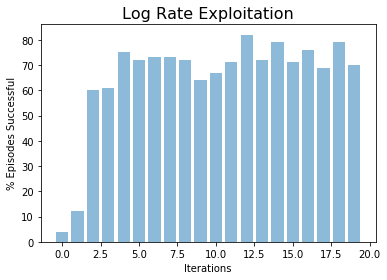

In [8]:
#%% ---> start of code
#%% <--- end of code
learning_rate = 0.02
discount_factor = 0.95
num_of_episodes = 10000
Q0 = np.random.uniform(size=[env.observation_space.n, env.action_space.n]) * 0.000001
Qsa, policies = runQLearning(learning_rate,discount_factor,num_of_episodes,Q0,explore_type='log')
percentSuccesses = []
for i, policy in enumerate(policies):
    succ = testPolicy(policy)
    percentSuccesses.append(succ)


plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iterations')
plt.title('Log Rate Exploitation', fontsize=16)
print('Q-learning (log) policy:', policy)

### BONUS: Hill Climbing (25%, granted only if Parts 1 and 2 are complete)

Demonstrate hill climbing, where your Q values are chosen randomly, and you save improvements, with new Q values to try as $$Q_{test}\leftarrow Q_{best}+rand(S,A)$$
Plot the a bar graph with x-axis labelling the iteration number when an improvement occurred, and y axis as the % of successful episodes. Run on N = 1000 iterations of hill climbing, with 100 episodes per iteration. 

(array([0, 3, 1, 1, 0, 0, 3, 0, 3, 1, 1, 1, 1, 2, 1, 1]), ': Hill-climbing policy')


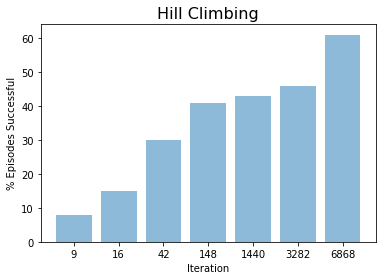

In [27]:
#%% ---> start of code
#%% <--- end of code
nState = env.observation_space.n
nAction = env.action_space.n
Qbest = np.random.rand(nState, nAction)
best_policy = np.random.randint(4, size=nState)
bestAccuracy = testPolicy(best_policy)
percentSuccesses = []
improvementsIndex = []

for index in range(10000):
    Qtest = Qbest + np.random.rand(nState, nAction)
    test_policy = getPolicy(Qtest)
    test_Accuracy = testPolicy(test_policy)
    if test_Accuracy > bestAccuracy:
        bestAccuracy = test_Accuracy
        best_policy = np.copy(test_policy)
        improvementsIndex.append(index)
        percentSuccesses.append(test_Accuracy)
plt.figure()
plt.bar(np.arange(len(improvementsIndex)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.xticks(np.arange(len(improvementsIndex)),improvementsIndex) 
plt.ylabel('% Episodes Successful')
plt.xlabel('Iteration')
plt.title('Hill Climbing',fontsize=16)
print(best_policy,': Hill-climbing policy')